<a href="https://colab.research.google.com/github/zxxoxnee/Machine-Learning/blob/master/Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 랜덤 포레스트(Random Forest)를 이용해서 악성 봇인지 탐지하기 



# https://www.kaggle.com/jsphyg/weather-dataset-rattle-package



## 관련 라이브러리 import

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
np.random.seed(42)

## 데이터 읽기

In [4]:
df = pd.read_csv('malware_lastline.csv')
df = pd.read_csv('malware_mta.csv')
df = pd.read_csv('malware_stratosphere.csv')
print(df.shape)

(7848, 421)


## 데이터 형상 파악하기

In [5]:
df.head()

,low_src_port,tls_dst_port,bytes_in,bytes_out,pkts_in,pkts_out,duration,pkt_lengths_00,pkt_lengths_01,pkt_lengths_02,pkt_lengths_03,pkt_lengths_04,pkt_lengths_05,pkt_lengths_06,pkt_lengths_07,pkt_lengths_08,pkt_lengths_09,pkt_lengths_10,pkt_lengths_11,pkt_lengths_12,pkt_lengths_13,pkt_lengths_14,pkt_lengths_15,pkt_lengths_16,pkt_lengths_17,pkt_lengths_18,pkt_lengths_19,pkt_lengths_20,pkt_lengths_21,pkt_lengths_22,pkt_lengths_23,pkt_lengths_24,pkt_lengths_25,pkt_lengths_26,pkt_lengths_27,pkt_lengths_28,pkt_lengths_29,pkt_lengths_30,pkt_lengths_31,pkt_lengths_32,...,sg_9,sg_10,sg_11,sg_12,sg_13,sg_14,sg_15,sg_16,sg_17,sg_18,sg_19,sg_20,sg_21,sg_22,sg_23,sg_24,sg_25,sg_26,sg_27,sg_28,sg_29,sg_30,sg_256,sg_257,sg_258,sg_259,sg_260,sg_65535,pf_0,pf_1,pf_2,pf_255,key_length,validity,nb_san,self-signed,date,source,family,label
0,0,1,2740,415,8,7,127,0.333,0.0,0.0,0.333,0.0,0.0,0.0,0.0,0.0,0.333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,512,1097,2,0,2016-06-22,stratosphere,vawtrak,1
1,0,1,2674,418,7,6,127,0.500,0.0,0.0,0.500,0.0,0.0,0.0,0.0,0.0,0.000,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,512,1097,2,0,2016-06-22,stratosphere,vawtrak,1
2,0,1,2740,415,8,7,127,0.333,0.0,0.0,0.333,0.0,0.0,0.0,0.0,0.0,0.333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,512,1097,2,0,2016-06-22,stratosphere,vawtrak,1
3,0,1,2672,416,7,6,127,0.333,0.0,0.0,0.333,0.0,0.0,0.0,0.0,0.0,0.333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,512,1097,2,0,2016-06-22,stratosphere,vawtrak,1
4,0,1,2670,414,7,6,127,0.333,0.0,0.0,0.333,0.0,0.0,0.0,0.0,0.0,0.333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,512,1097,2,0,2016-06-22,stratosphere,vawtrak,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7848 entries, 0 to 7847
Columns: 421 entries, low_src_port to label
dtypes: float64(203), int64(215), object(3)
memory usage: 25.2+ MB


In [7]:
df.describe()  #describe 메서드를 통해 간단하게 표에 대한 요약정보를 볼 수 있음.

,low_src_port,tls_dst_port,bytes_in,bytes_out,pkts_in,pkts_out,duration,pkt_lengths_00,pkt_lengths_01,pkt_lengths_02,pkt_lengths_03,pkt_lengths_04,pkt_lengths_05,pkt_lengths_06,pkt_lengths_07,pkt_lengths_08,pkt_lengths_09,pkt_lengths_10,pkt_lengths_11,pkt_lengths_12,pkt_lengths_13,pkt_lengths_14,pkt_lengths_15,pkt_lengths_16,pkt_lengths_17,pkt_lengths_18,pkt_lengths_19,pkt_lengths_20,pkt_lengths_21,pkt_lengths_22,pkt_lengths_23,pkt_lengths_24,pkt_lengths_25,pkt_lengths_26,pkt_lengths_27,pkt_lengths_28,pkt_lengths_29,pkt_lengths_30,pkt_lengths_31,pkt_lengths_32,...,sg_6,sg_7,sg_8,sg_9,sg_10,sg_11,sg_12,sg_13,sg_14,sg_15,sg_16,sg_17,sg_18,sg_19,sg_20,sg_21,sg_22,sg_23,sg_24,sg_25,sg_26,sg_27,sg_28,sg_29,sg_30,sg_256,sg_257,sg_258,sg_259,sg_260,sg_65535,pf_0,pf_1,pf_2,pf_255,key_length,validity,nb_san,self-signed,label
count,7848.0,7848.000000,7848.000000,7848.000000,7848.000000,7848.000000,7848.000000,7848.000000,7848.000000,7848.000000,7848.000000,7848.000000,7848.000000,7848.000000,7848.000000,7848.000000,7848.000000,7848.000000,7848.00000,7848.000000,7848.000000,7848.000000,7848.0,7848.000000,7848.000000,7848.000000,7848.000000,7848.000000,7848.000000,7848.000000,7848.000000,7848.000000,7848.000000,7848.0,7848.000000,7848.000000,7848.000000,7848.000000,7848.000000,7848.000000,...,7848.0,7848.0,7848.0,7848.0,7848.0,7848.0,7848.0,7848.0,7848.0,7848.0,7848.0,7848.0,7848.0,7848.0,7848.0,7848.0,7848.0,7848.000000,7848.000000,7848.0,7848.0,7848.0,7848.0,7848.0,7848.0,7848.0,7848.0,7848.0,7848.0,7848.0,7848.0,7848.000000,7848.0,7848.0,7848.0,7848.000000,7848.000000,7848.000000,7848.000000,7848.0
mean,0.0,0.717125,3081.308614,1425.383282,9.982543,9.180173,27.304281,0.219620,0.236557,0.051290,0.031549,0.200756,0.016469,0.079374,0.057554,0.014523,0.092062,0.255205,0.13099,0.005889,0.213348,0.011424,0.0,0.023700,0.031792,0.000064,0.171346,0.279687,0.052798,0.009265,0.002675,0.000127,0.000056,0.0,0.000042,0.000446,0.008233,0.257157,0.003313,0.002548,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.998598,0.998598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.998598,0.0,0.0,0.0,977.875637,267.617355,3.314857,0.444827,1.0
std,0.0,0.450425,5715.861373,2378.795352,10.568850,7.456866,48.429632,0.224431,0.267684,0.212297,0.147802,0.368507,0.106384,0.158561,0.154034,0.079954,0.149218,0.295360,0.26608,0.060638,0.407062,0.072889,0.0,0.144166,0.175365,0.005644,0.285259,0.444349,0.222551,0.064975,0.044419,0.007981,0.002552,0.0,0.003759,0.019995,0.071916,0.437074,0.057466,0.050421,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037414,0.037414,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037414,0.0,0.0,0.0,688.685831,5861.845841,14.505761,0.496978,0.0
min,0.0,0.000000,219.000000,405.000000,4.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,512.000000,-39712.000000,0.000000,0.000000,1.0
25%,0.0,0.000000,1348.000000,538.000000,7.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,512.000000,182.000000,0.000000,0.000000,1.0
50%,0.0,1.000000,2204.000000,693.000000,8.000000,8.000000,1.000000,0.333000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

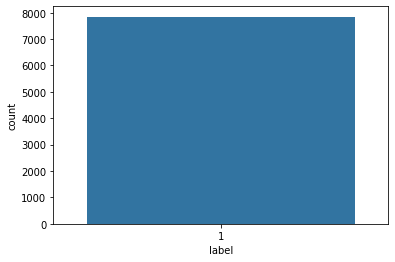

In [8]:
sns.countplot(x="label", data=df)

## 상관 분석(Correlation Analysis) 수행해보기

In [9]:
# Yes/No 값을 0, 1로 변경합니다.
#temp_df = df.copy()
#temp_df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
#temp_df['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace = True)

#corr = temp_df.corr()
#plt.figure(figsize=(25, 25));
#sns.heatmap(corr,
 #           vmax=0.8,
 #           linewidths=0.01,
 #           square=True,
  #          annot=True,
   ##         cmap='YlGnBu');
#plt.title('Feature Correlation');

# 결측치(null값) 확인하기

In [10]:
df.isnull().mean().sort_values()

low_src_port    0.0
cs_c007         0.0
cs_c005         0.0
cs_c004         0.0
cs_c003         0.0
               ... 
pkt_times_27    0.0
pkt_times_26    0.0
pkt_times_25    0.0
pkt_times_49    0.0
label           0.0
Length: 421, dtype: float64

## categorical column 확인하기

In [11]:
categorical = [col for col in df.columns if df[col].dtypes == 'object']
print(categorical)

['date', 'source', 'family']


# numerical column 확인하기

In [12]:
numerical = [col for col in df.columns if df[col].dtypes != 'object']
print(numerical)

['low_src_port', 'tls_dst_port', 'bytes_in', 'bytes_out', 'pkts_in', 'pkts_out', 'duration', 'pkt_lengths_00', 'pkt_lengths_01', 'pkt_lengths_02', 'pkt_lengths_03', 'pkt_lengths_04', 'pkt_lengths_05', 'pkt_lengths_06', 'pkt_lengths_07', 'pkt_lengths_08', 'pkt_lengths_09', 'pkt_lengths_10', 'pkt_lengths_11', 'pkt_lengths_12', 'pkt_lengths_13', 'pkt_lengths_14', 'pkt_lengths_15', 'pkt_lengths_16', 'pkt_lengths_17', 'pkt_lengths_18', 'pkt_lengths_19', 'pkt_lengths_20', 'pkt_lengths_21', 'pkt_lengths_22', 'pkt_lengths_23', 'pkt_lengths_24', 'pkt_lengths_25', 'pkt_lengths_26', 'pkt_lengths_27', 'pkt_lengths_28', 'pkt_lengths_29', 'pkt_lengths_30', 'pkt_lengths_31', 'pkt_lengths_32', 'pkt_lengths_33', 'pkt_lengths_34', 'pkt_lengths_35', 'pkt_lengths_36', 'pkt_lengths_37', 'pkt_lengths_38', 'pkt_lengths_39', 'pkt_lengths_40', 'pkt_lengths_41', 'pkt_lengths_42', 'pkt_lengths_43', 'pkt_lengths_44', 'pkt_lengths_45', 'pkt_lengths_46', 'pkt_lengths_47', 'pkt_lengths_48', 'pkt_lengths_49', 'pkt_le

# 결측치 개수 확인하기

In [13]:
# categorical column의 null 비율
df[categorical].isnull().mean().sort_values()

date      0.0
source    0.0
family    0.0
dtype: float64

In [22]:
# numerical column의 null 비율
df[numerical].isnull().mean().sort_values()

low_src_port      0.0
cs_c004           0.0
cs_c003           0.0
cs_c002           0.0
cs_1304           0.0
                 ... 
pkt_times_27      0.0
pkt_times_26      0.0
pkt_times_25      0.0
pkt_lengths_97    0.0
label             0.0
Length: 418, dtype: float64

In [14]:
# numerical value를 가진 column은 중위값(meidan)으로 결측치를 채웁니다.
for col in numerical:
    if df[col].isnull().mean()>0:
        col_median=df[col].median()
        df[col].fillna(col_median, inplace=True)

In [15]:
for col in categorical:
    if df[col].isnull().mean()>0:
        print(col, (df[col].isnull().mean()))

In [16]:
# categorical value를 가진 column은 최빈값(mode)으로 결측치를 채웁니다. 
df['date'].fillna(df['date'].mode()[0], inplace=True)
df['source'].fillna(df['source'].mode()[0], inplace=True)
df['family'].fillna(df['family'].mode()[0], inplace=True)
#df['RainToday'].fillna(df['RainToday'].mode()[0], inplace=True)

In [17]:
df.head()

,low_src_port,tls_dst_port,bytes_in,bytes_out,pkts_in,pkts_out,duration,pkt_lengths_00,pkt_lengths_01,pkt_lengths_02,pkt_lengths_03,pkt_lengths_04,pkt_lengths_05,pkt_lengths_06,pkt_lengths_07,pkt_lengths_08,pkt_lengths_09,pkt_lengths_10,pkt_lengths_11,pkt_lengths_12,pkt_lengths_13,pkt_lengths_14,pkt_lengths_15,pkt_lengths_16,pkt_lengths_17,pkt_lengths_18,pkt_lengths_19,pkt_lengths_20,pkt_lengths_21,pkt_lengths_22,pkt_lengths_23,pkt_lengths_24,pkt_lengths_25,pkt_lengths_26,pkt_lengths_27,pkt_lengths_28,pkt_lengths_29,pkt_lengths_30,pkt_lengths_31,pkt_lengths_32,...,sg_9,sg_10,sg_11,sg_12,sg_13,sg_14,sg_15,sg_16,sg_17,sg_18,sg_19,sg_20,sg_21,sg_22,sg_23,sg_24,sg_25,sg_26,sg_27,sg_28,sg_29,sg_30,sg_256,sg_257,sg_258,sg_259,sg_260,sg_65535,pf_0,pf_1,pf_2,pf_255,key_length,validity,nb_san,self-signed,date,source,family,label
0,0,1,2740,415,8,7,127,0.333,0.0,0.0,0.333,0.0,0.0,0.0,0.0,0.0,0.333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,512,1097,2,0,2016-06-22,stratosphere,vawtrak,1
1,0,1,2674,418,7,6,127,0.500,0.0,0.0,0.500,0.0,0.0,0.0,0.0,0.0,0.000,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,512,1097,2,0,2016-06-22,stratosphere,vawtrak,1
2,0,1,2740,415,8,7,127,0.333,0.0,0.0,0.333,0.0,0.0,0.0,0.0,0.0,0.333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,512,1097,2,0,2016-06-22,stratosphere,vawtrak,1
3,0,1,2672,416,7,6,127,0.333,0.0,0.0,0.333,0.0,0.0,0.0,0.0,0.0,0.333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,512,1097,2,0,2016-06-22,stratosphere,vawtrak,1
4,0,1,2670,414,7,6,127,0.333,0.0,0.0,0.333,0.0,0.0,0.0,0.0,0.0,0.333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,512,1097,2,0,2016-06-22,stratosphere,vawtrak,1


In [29]:
# 날짜 column을 drop합니다.
#df.drop(['Date'], axis=1, inplace=True)

KeyError: ignored

In [ ]:
#df.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,Albury,13.4,22.9,0.6,4.8,8.4,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,5.0,16.9,21.8,No,No
1,Albury,7.4,25.1,0.0,4.8,8.4,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,5.0,5.0,17.2,24.3,No,No
2,Albury,12.9,25.7,0.0,4.8,8.4,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,5.0,2.0,21.0,23.2,No,No
3,Albury,9.2,28.0,0.0,4.8,8.4,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,5.0,5.0,18.1,26.5,No,No
4,Albury,17.5,32.3,1.0,4.8,8.4,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [18]:
df.isnull().mean().sort_values()

low_src_port    0.0
cs_c007         0.0
cs_c005         0.0
cs_c004         0.0
cs_c003         0.0
               ... 
pkt_times_27    0.0
pkt_times_26    0.0
pkt_times_25    0.0
pkt_times_49    0.0
label           0.0
Length: 421, dtype: float64

## RainTomorrow가 null인 row들을 삭제합니다.

In [19]:
df.shape

(7848, 421)

In [20]:
df.dropna(how='any', inplace=True)

In [21]:
df.shape

(7848, 421)

# Yes/No 값에 대한 변환

In [ ]:
# Yes/No 값을 0, 1로 변경합니다.
#df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
#df['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace = True)

## categorical value에 one-hot encoding 적용하기

In [22]:
df = pd.get_dummies(df, columns = ['date', 'source', 'family'])

In [23]:
df.head()

,low_src_port,tls_dst_port,bytes_in,bytes_out,pkts_in,pkts_out,duration,pkt_lengths_00,pkt_lengths_01,pkt_lengths_02,pkt_lengths_03,pkt_lengths_04,pkt_lengths_05,pkt_lengths_06,pkt_lengths_07,pkt_lengths_08,pkt_lengths_09,pkt_lengths_10,pkt_lengths_11,pkt_lengths_12,pkt_lengths_13,pkt_lengths_14,pkt_lengths_15,pkt_lengths_16,pkt_lengths_17,pkt_lengths_18,pkt_lengths_19,pkt_lengths_20,pkt_lengths_21,pkt_lengths_22,pkt_lengths_23,pkt_lengths_24,pkt_lengths_25,pkt_lengths_26,pkt_lengths_27,pkt_lengths_28,pkt_lengths_29,pkt_lengths_30,pkt_lengths_31,pkt_lengths_32,...,sg_257,sg_258,sg_259,sg_260,sg_65535,pf_0,pf_1,pf_2,pf_255,key_length,validity,nb_san,self-signed,label,date_2016-06-22,date_2016-08-03,date_2016-08-04,date_2016-09-02,date_2017-02-13,date_2017-02-14,date_2017-02-27,date_2017-03-29,date_2017-03-30,date_2017-04-12,date_2017-04-17,date_2017-04-18,date_2017-05-15,date_2017-05-16,date_2017-06-07,date_2017-06-24,date_2018-01-29,date_2018-01-30,date_2018-04-03,source_stratosphere,family_dridex,family_locky,family_miuref,family_trickbot,family_vawtrak,family_zeus
0,0,1,2740,415,8,7,127,0.333,0.0,0.0,0.333,0.0,0.0,0.0,0.0,0.0,0.333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,512,1097,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,0,1,2674,418,7,6,127,0.500,0.0,0.0,0.500,0.0,0.0,0.0,0.0,0.0,0.000,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,512,1097,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,0,1,2740,415,8,7,127,0.333,0.0,0.0,0.333,0.0,0.0,0.0,0.0,0.0,0.333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,512,1097,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,0,1,2672,416,7,6,127,0.333,0.0,0.0,0.333,0.0,0.0,0.0,0.0,0.0,0.333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,512,1097,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,0,1,2670,414,7,6,127,0.333,0.0,0.0,0.333,0.0,0.0,0.0,0.0,0.0,0.333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,512,1097,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [24]:
df.shape

(7848, 444)

# 트레이닝 데이터를 준비합니다.

In [25]:
X = df.drop(['label'], axis=1)
y = df['label']

In [39]:
X

,low_src_port,tls_dst_port,bytes_in,bytes_out,pkts_in,pkts_out,duration,pkt_lengths_00,pkt_lengths_01,pkt_lengths_02,pkt_lengths_03,pkt_lengths_04,pkt_lengths_05,pkt_lengths_06,pkt_lengths_07,pkt_lengths_08,pkt_lengths_09,pkt_lengths_10,pkt_lengths_11,pkt_lengths_12,pkt_lengths_13,pkt_lengths_14,pkt_lengths_15,pkt_lengths_16,pkt_lengths_17,pkt_lengths_18,pkt_lengths_19,pkt_lengths_20,pkt_lengths_21,pkt_lengths_22,pkt_lengths_23,pkt_lengths_24,pkt_lengths_25,pkt_lengths_26,pkt_lengths_27,pkt_lengths_28,pkt_lengths_29,pkt_lengths_30,pkt_lengths_31,pkt_lengths_32,...,sg_256,sg_257,sg_258,sg_259,sg_260,sg_65535,pf_0,pf_1,pf_2,pf_255,key_length,validity,nb_san,self-signed,date_2016-06-22,date_2016-08-03,date_2016-08-04,date_2016-09-02,date_2017-02-13,date_2017-02-14,date_2017-02-27,date_2017-03-29,date_2017-03-30,date_2017-04-12,date_2017-04-17,date_2017-04-18,date_2017-05-15,date_2017-05-16,date_2017-06-07,date_2017-06-24,date_2018-01-29,date_2018-01-30,date_2018-04-03,source_stratosphere,family_dridex,family_locky,family_miuref,family_trickbot,family_vawtrak,family_zeus
0,0,1,2740,415,8,7,127,0.333,0.0,0.0,0.333,0.0,0.0,0.0,0.000,0.0,0.333,1.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0,512,1097,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,0,1,2674,418,7,6,127,0.500,0.0,0.0,0.500,0.0,0.0,0.0,0.000,0.0,0.000,0.500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0,512,1097,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,0,1,2740,415,8,7,127,0.333,0.0,0.0,0.333,0.0,0.0,0.0,0.000,0.0,0.333,1.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0,512,1097,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,0,1,2672,416,7,6,127,0.333,0.0,0.0,0.333,0.0,0.0,0.0,0.000,0.0,0.333,1.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0,512,1097,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,0,1,2670,414,7,6,127,0.333,0.0,0.0,0.333,0.0,0.0,0.0,0.000,0.0,0.333,1.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0,512,1097,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7843,0,1,2205,5984,8,13,302,0.000,1.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0,512,1097,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0
7844,0,1,2204,5984,7,10,0,0.000,1.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0,512,1097,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0
7845,0,0,1358,6192,10,11,1,0.000,1.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.500,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0,2048,182,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0
7846,0,0,1440,6074,9,11,0,0.333,0.0,0.0,0.000,0.0,0.0,0.0,0.333,0.0,0.333,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0,2048,182,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0


In [26]:
y

0       1
1       1
2       1
3       1
4       1
       ..
7843    1
7844    1
7845    1
7846    1
7847    1
Name: label, Length: 7848, dtype: int64

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## 결정 트리(Decision Tree)로 내일 비가 올지 안올지 예측해보기

In [28]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)
score = accuracy_score(y_test,y_pred)
print('결정 트리(Decision Tree) Accuracy :',score)

결정 트리(Decision Tree) Accuracy : 1.0


## 랜덤 포레스트(Random Forest)로 내일 비가 올지 안올지 예측해보기

In [29]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
score = accuracy_score(y_test, y_pred)
print('랜덤 포레스트(Random Forest) Accuracy :',score)

랜덤 포레스트(Random Forest) Accuracy : 1.0
